In [ ]:
import os, sys, csv
import math
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!ls "/content/drive/My Drive/AIProject"

In [ ]:
%cd "/content/drive/My Drive/AIProject"

In [ ]:
pwd

In [ ]:
data = pd.read_csv('FB.csv')
print (data.head())

In [ ]:
#Reading as datetime format:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
# dateparse('1962-01')
data = pd.read_csv('FB.csv', parse_dates=['date'], index_col='date', date_parser=dateparse)
print (data.head())

In [ ]:
#check datatype of index
data.index

In [ ]:
#convert to time series:
ts = data['adj_close']
ts.head(10)

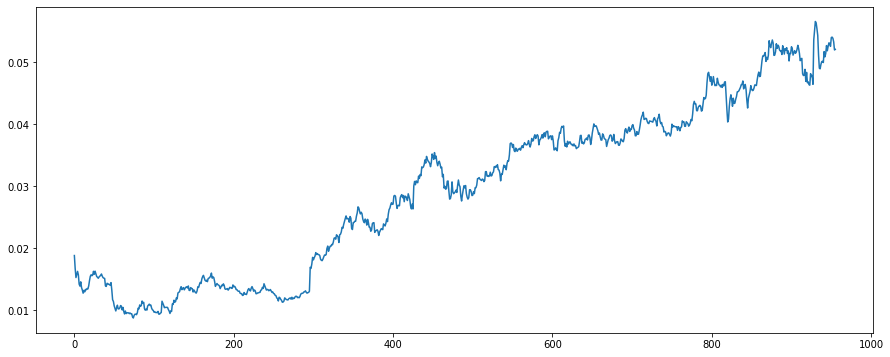

In [ ]:
#Plot the time-series
plt.plot(ts)

In [ ]:
#Checking for stationarity
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['open','high','10_day_volatility', '50_day_moving_avg'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

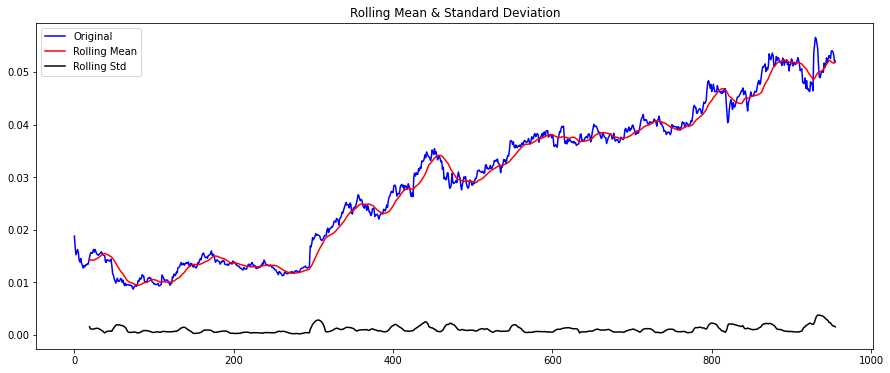

Results of Dickey-Fuller Test:
open                     -0.026673
high                      0.956270
10_day_volatility         6.000000
50_day_moving_avg       949.000000
Critical Value (1%)      -3.437259
Critical Value (5%)      -2.864590
Critical Value (10%)     -2.568394
dtype: float64


In [ ]:
test_stationarity(ts)

**Making Data Stationary**

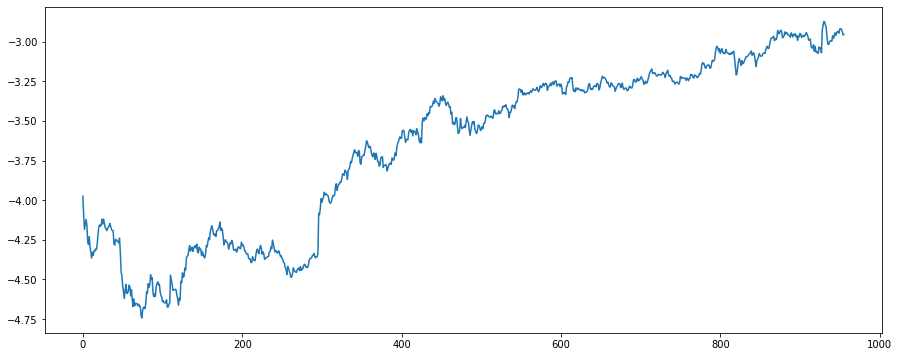

In [ ]:
#Estimating & Eliminating Trend
ts_log = np.log(ts)
plt.plot(ts_log)

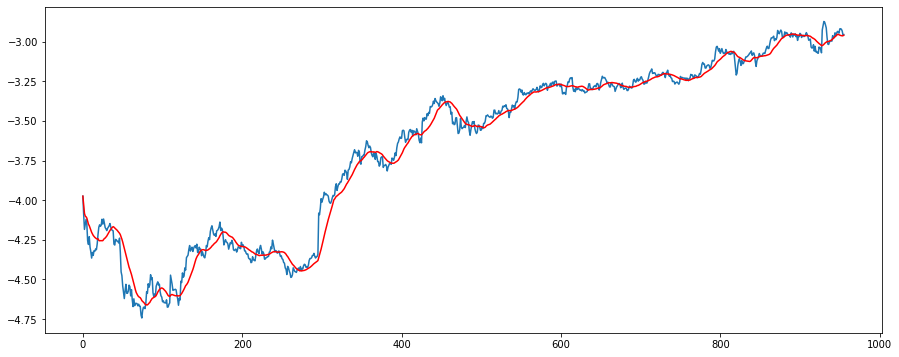

In [ ]:
#Smoothing: Moving average MA
z
moving_avg = ts_log.rolling(20, min_periods=1).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [ ]:
print (moving_avg)

0     -3.974799
1     -4.032988
2     -4.083470
3     -4.100773
4     -4.104820
         ...   
951   -2.961032
952   -2.962431
953   -2.963391
954   -2.962599
955   -2.959594
Name: adj_close, Length: 956, dtype: float64


In [ ]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(15)

0     0.000000
1    -0.058189
2    -0.100963
3    -0.051911
4    -0.016184
5    -0.042234
6    -0.122906
7    -0.127489
8    -0.069940
9    -0.122004
10   -0.138211
11   -0.162482
12   -0.117038
13   -0.126159
14   -0.090136
Name: adj_close, dtype: float64

In [ ]:
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head()

0    0.000000
1   -0.058189
2   -0.100963
3   -0.051911
4   -0.016184
Name: adj_close, dtype: float64

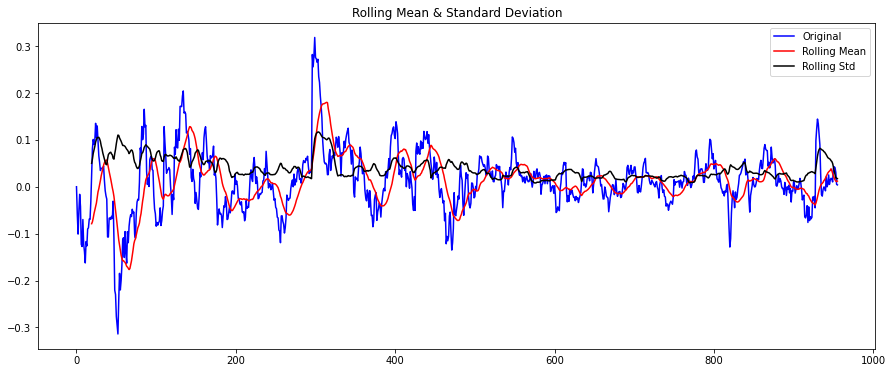

Results of Dickey-Fuller Test:
open                   -6.121651e+00
high                    8.825796e-08
10_day_volatility       0.000000e+00
50_day_moving_avg       9.550000e+02
Critical Value (1%)    -3.437216e+00
Critical Value (5%)    -2.864571e+00
Critical Value (10%)   -2.568384e+00
dtype: float64


In [ ]:
test_stationarity(ts_log_moving_avg_diff)

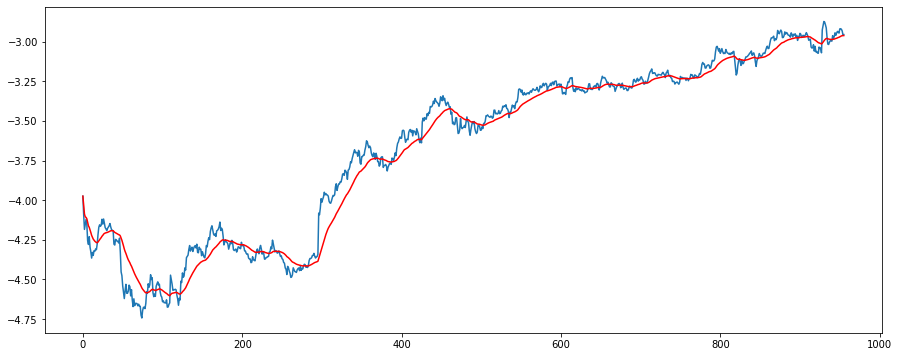

In [ ]:
#Exponentially Weighted Moving Average
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
# expwighted_avg.plot(style='k--')

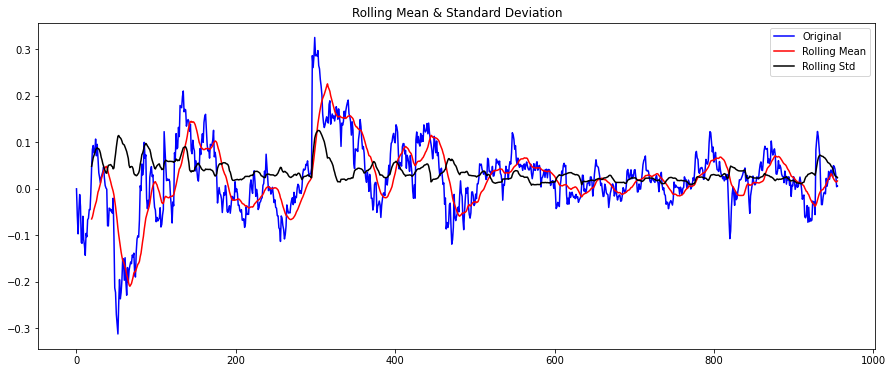

Results of Dickey-Fuller Test:
open                     -5.193435
high                      0.000009
10_day_volatility         0.000000
50_day_moving_avg       955.000000
Critical Value (1%)      -3.437216
Critical Value (5%)      -2.864571
Critical Value (10%)     -2.568384
dtype: float64


In [ ]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

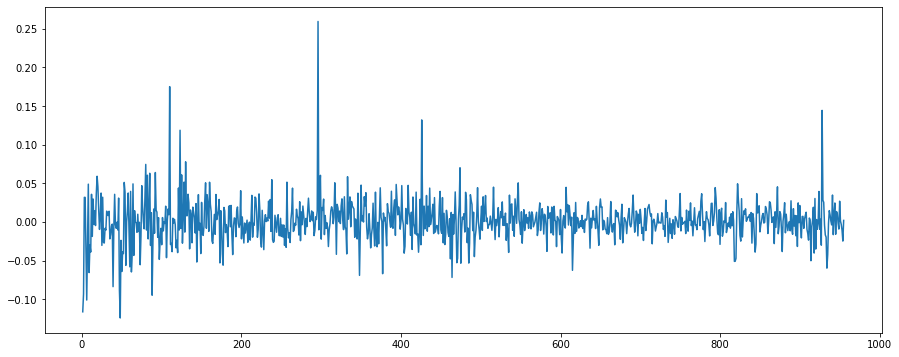

In [ ]:
#Eliminating Trend and Seasonality
#Differencing:
#Take first difference:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

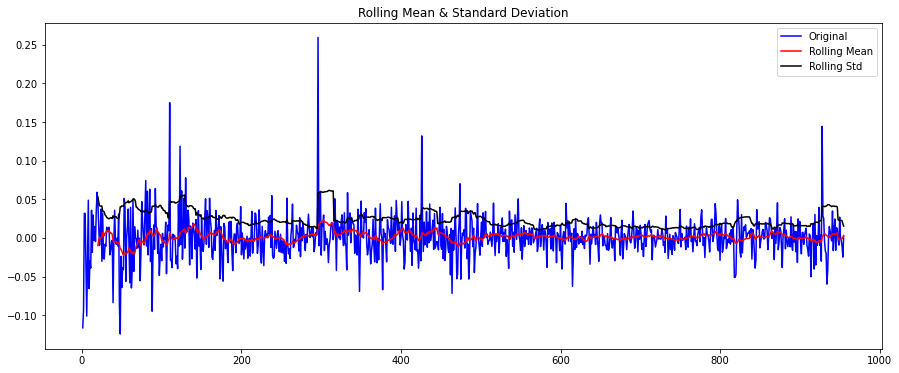

Results of Dickey-Fuller Test:
open                    -30.458521
high                      0.000000
10_day_volatility         0.000000
50_day_moving_avg       954.000000
Critical Value (1%)      -3.437223
Critical Value (5%)      -2.864574
Critical Value (10%)     -2.568386
dtype: float64


In [ ]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

**Decomposition**

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

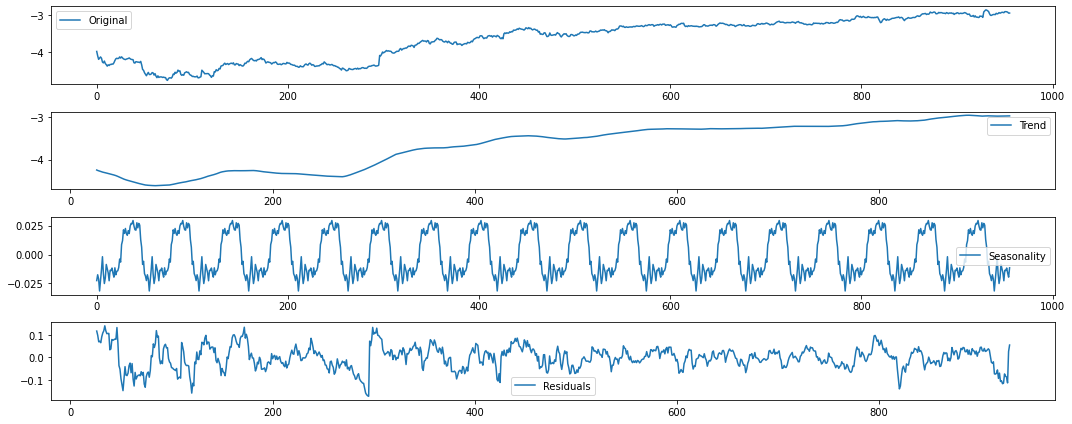

In [ ]:
decomposition = seasonal_decompose(ts_log, freq=52)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

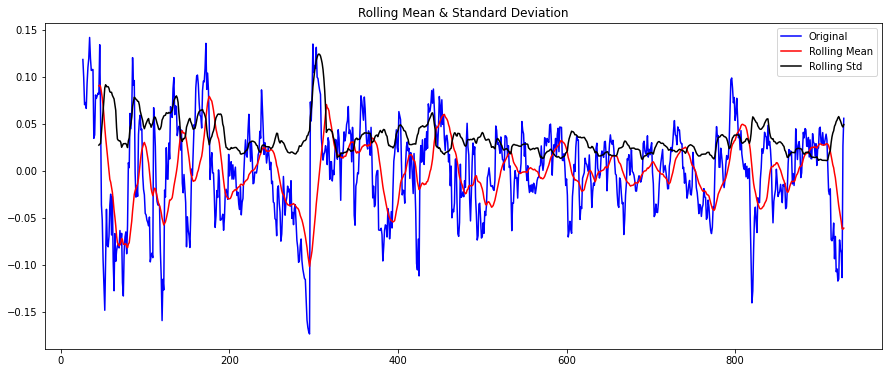

Results of Dickey-Fuller Test:
open                   -7.820168e+00
high                    6.703107e-12
10_day_volatility       7.000000e+00
50_day_moving_avg       8.960000e+02
Critical Value (1%)    -3.437669e+00
Critical Value (5%)    -2.864771e+00
Critical Value (10%)   -2.568490e+00
dtype: float64


In [ ]:
ts_log_decompose = decomposition.resid
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

**Final Forecasting**

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


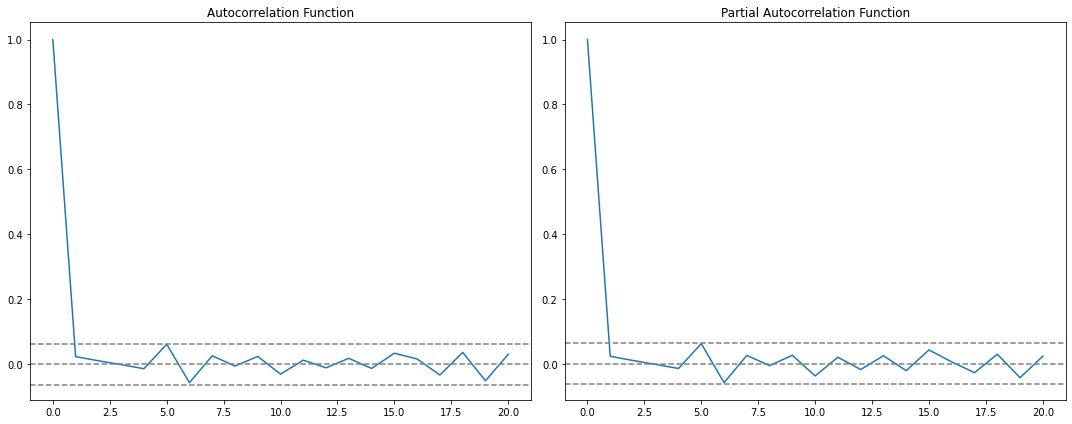

In [ ]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Text(0.5, 1.0, 'RSS: 0.6808')

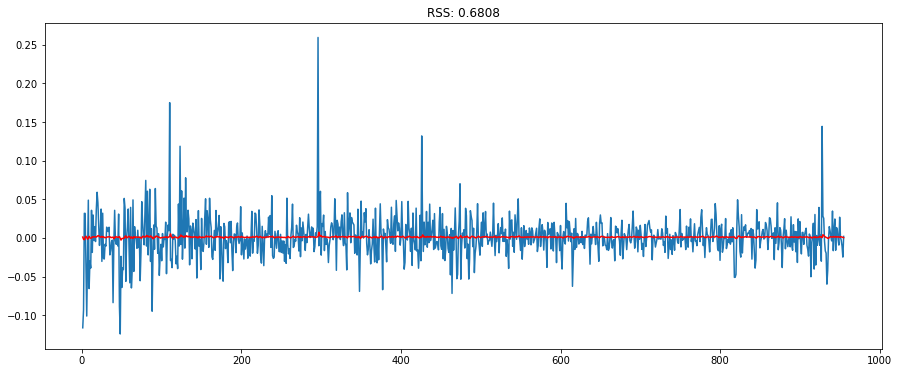

In [ ]:
#AR model:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

Text(0.5, 1.0, 'RSS: 0.6808')

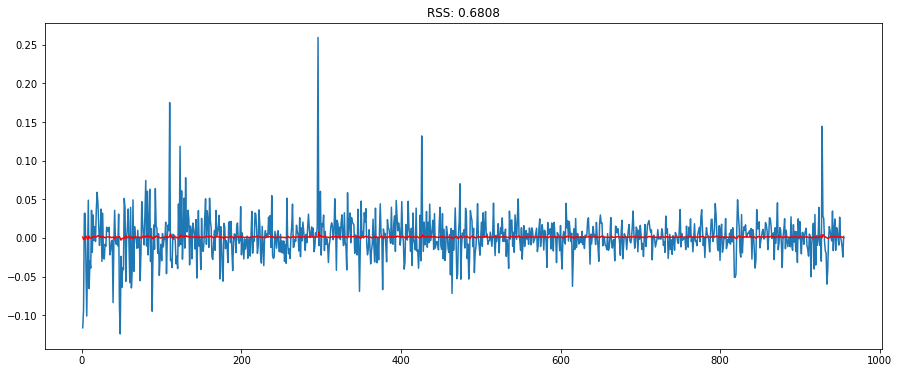

In [ ]:
#MA model:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

Text(0.5, 1.0, 'RSS (Root Squared Sum): 0.6766')

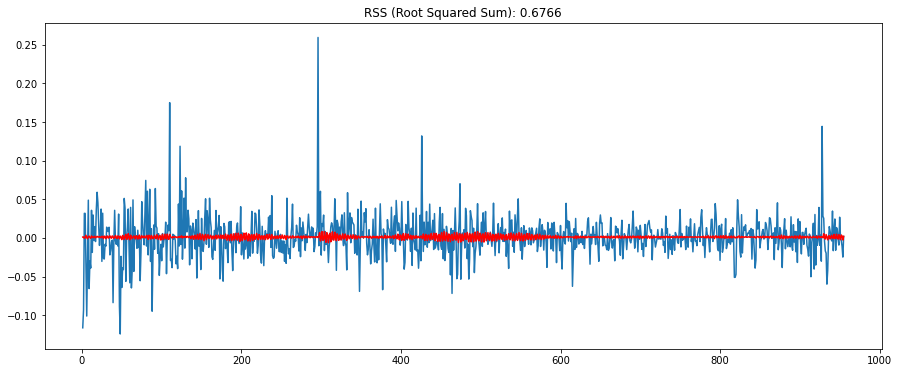

In [ ]:
#ARIMA Model:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS (Root Squared Sum): %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

**Convert to original scale**

In [ ]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

1    0.001067
2    0.001249
3   -0.000572
4    0.000660
5    0.003354
dtype: float64


In [ ]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

1    0.001067
2    0.002316
3    0.001745
4    0.002405
5    0.005759
dtype: float64


In [ ]:
predictions_ARIMA_log = pd.Series(ts_log.loc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

0   -3.974799
1   -3.973732
2   -3.972483
3   -3.973055
4   -3.972394
dtype: float64

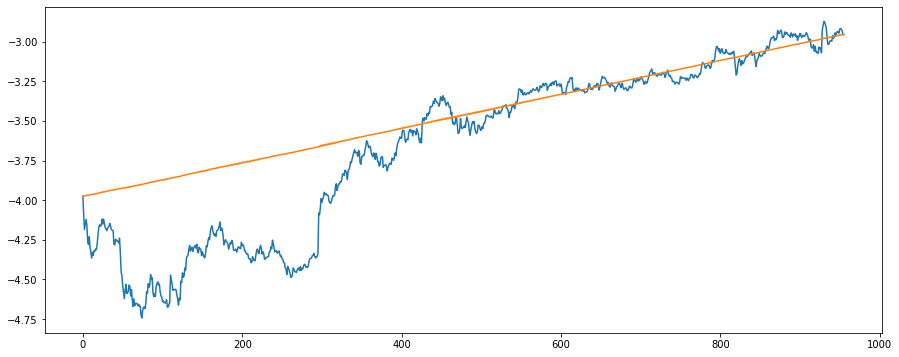

In [ ]:
plt.plot(ts_log)
plt.plot(predictions_ARIMA_log)

Text(0.5, 1.0, 'RMSE: 0.0059')

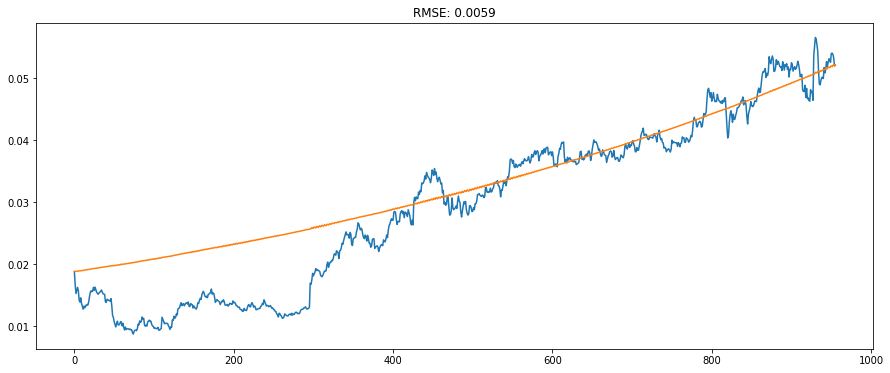

In [ ]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [ ]:
predictions_ARIMA.head()

0    0.018783
1    0.018803
2    0.018827
3    0.018816
4    0.018828
dtype: float64